In [34]:
conda install -c conda-forge mapclassify


Solving environment: done

## Package Plan ##

  environment location: /Users/chen/opt/anaconda3

  added / updated specs:
    - mapclassify


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    deprecated-1.2.7           |             py_0          10 KB  conda-forge
    mapclassify-2.2.0          |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h0b31af3_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  deprecated         conda-forge/noarch::deprecated-1.2.7-py_0
  mapclassify        conda-forge/noarch::mapclassify-2.2.0-py_0

The following pac

In [35]:
import geopandas as gp
import mapclassify as mc
import fiona
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [2]:
NY_GEO = gp.read_file("nyc/geo_export_ed1b9dba-ece4-470b-8a1e-2954c9ff29fe.shp", driver='shapefile')
CITI = pd.read_csv('citi_df_sum.csv') #201911-citibike-tripdata.csv #citi_df_sum.csv
NY_STATION = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
NY_LINES = gp.read_file('line/geo_export_1600b818-1305-4ac8-b2d4-6d1ad4428095.shp')
#TURNSTILE = pd.read_csv('turnstile/cleaned_turnstile_daily.csv')
#BLYN_CITI_END=gp.read_file("BLYN_CITI_END.shp")
#station = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/Stations.csv")

In [3]:
def coord_start(row):
    return Point(row['start station longitude'], row['start station latitude'])

def line_up(row):
    return LineString([[row['start station longitude'], row['start station latitude']], [row['end station longitude'], row['end station latitude']]])

In [4]:
scope=['Brooklyn','Queens','Manhattan']
SCOPE=NY_GEO[NY_GEO['boro_name'].isin(scope)]

In [5]:
BLYN = NY_GEO[(NY_GEO.boro_name == 'Brooklyn')]
CITI_DF_END = gp.GeoDataFrame(
    CITI, 
    crs = {'init': 'epsg:4326'},
    geometry = gp.points_from_xy(CITI['end station longitude'], CITI['end station latitude']))
STATION_DF = gp.GeoDataFrame(
    NY_STATION, 
    crs = {'init': 'epsg:4326'},
    geometry = gp.points_from_xy(NY_STATION['GTFS Longitude'], NY_STATION['GTFS Latitude']))

In [6]:
BLYN_LINES = NY_LINES[NY_LINES.geometry.intersects(BLYN.geometry.unary_union)]

In [7]:
BLYN_STATION = STATION_DF[STATION_DF.geometry.intersects(BLYN.geometry.unary_union)]

In [8]:
BLYN_STATION['geometry']=BLYN_STATION['geometry'].buffer(.002)

/Users/chen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
BLYN_CITI_NEAR_STATION = CITI_DF_END[CITI_DF_END.geometry.intersects(BLYN_STATION.geometry.unary_union)]

In [10]:
BLYN_CITI_STATION_MERGED = gp.sjoin(BLYN_CITI_NEAR_STATION, BLYN_STATION, how="inner", op='intersects')

In [11]:
BLYN_CITI_STATION_MERGED['count']=1

In [12]:
BLYN_CITI_STATION_MERGED_SUM = (BLYN_CITI_STATION_MERGED
 .groupby(['Stop Name'])
 ['count'].sum()
 .reset_index()
 .sort_values("count", ascending=False))

In [13]:
BLYN_CITI_STATION_MERGED_TOP10 = BLYN_CITI_STATION_MERGED.merge(BLYN_CITI_STATION_MERGED_SUM.head(10),
                                                              on=['Stop Name'], how='inner')

In [14]:
BLYN_CITI_STATION_MERGED_TOP10=BLYN_CITI_STATION_MERGED_TOP10[BLYN_CITI_STATION_MERGED_TOP10['counts']>10]

In [15]:
BLYN_CITI_STATION_MERGED_START_TOP10 = gp.GeoDataFrame(
    BLYN_CITI_STATION_MERGED_TOP10.copy(),
    crs = {'init': 'epsg:4326'},
    geometry = gp.points_from_xy(BLYN_CITI_STATION_MERGED_TOP10['start station longitude'], BLYN_CITI_STATION_MERGED_TOP10['start station latitude']),
    )

In [16]:
BLYN_CITI_STATION_MERGED_START_TOP10_PATH = BLYN_CITI_STATION_MERGED_TOP10.copy()

In [17]:
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.drop("geometry",axis=1, inplace=True)

In [18]:
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.columns

Index(['Unnamed: 0', 'start station id', 'start station name',
       'start station latitude', 'start station longitude', 'end station id',
       'end station name', 'end station latitude', 'end station longitude',
       'counts', 'index_right', 'Station ID', 'Complex ID', 'GTFS Stop ID',
       'Division', 'Line', 'Stop Name', 'Borough', 'Daytime Routes',
       'Structure', 'GTFS Latitude', 'GTFS Longitude', 'North Direction Label',
       'South Direction Label', 'count_x', 'count_y'],
      dtype='object')

In [19]:
line_up = BLYN_CITI_STATION_MERGED_START_TOP10_PATH.apply(line_up, axis=1)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH['geometry'] = line_up

In [20]:
BLYN_CITI_STATION_MERGED_START_TOP10_PATH = gp.GeoDataFrame(
    BLYN_CITI_STATION_MERGED_START_TOP10_PATH,
    crs = {'init': 'epsg:4326'})
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.set_geometry('geometry')

,Unnamed: 0,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,counts,...,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,count_x,count_y,geometry
0,115770,460.0,S 4 St & Wythe Ave,40.712859,-73.965903,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3678,...,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283,"LINESTRING (-73.96590 40.71286, -73.95851 40.7..."
1,127387,481.0,S 3 St & Bedford Ave,40.712605,-73.962644,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3448,...,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283,"LINESTRING (-73.96264 40.71260, -73.95851 40.7..."
2,160549,2002.0,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3183,...,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283,"LINESTRING (-73.96320 40.71689, -73.95851 40.7..."
3,84114,389.0,Broadway & Berry St,40.710446,-73.965251,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,2117,...,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283,"LINESTRING (-73.96525 40.71045, -73.95851 40.7..."
4,190777,3100.0,Nassau Ave & Newell St,40.724813,-73.947526,3715.0,Driggs Ave & N 9 St,40.718170,-73.955201,2061,...,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283,"LINESTRING (-73.94753 40.72481, -73.95520 40.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18426,64397,344.0,Monroe St & Bedford Ave,40.685144,-73.953809,3415.0,Prospect Pl & 6 Ave,40.679331,-73.975195,11,...,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507,"LINESTRING (-73.95381 40.68514, -73.97520 40.6..."
18427,353288,3676.0,Van Brunt St & Van Dyke St,40.675833,-74.014726,3414.0,Bergen St & Flatbush Ave,40.680945,-73.975673,11,...,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507,"LINESTRING (-74.01473 40.67583, -73.97567 40.6..."
18428,229485,3241.0,Monroe St & Tompkins Ave,40.686203,-73.944694,3415.0,Prospect Pl & 6 Ave,40.679331,-73.975195,11,...,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507,"LINESTRING (-73.94469 40.68620, -73.97520 40.6..."
18429,103958,435.0,W 21 St & 6 Ave,40.741740,-73.994156,3415.0,Prospect Pl & 6 Ave,40.679331,-73.975195,11,...,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507,"LINESTRING (-73.99416 40.74174, -73.97520 40.6..."


NY_GEO = NY_GEO.to_crs(epsg=3857)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH = BLYN_CITI_STATION_MERGED_START_TOP10_PATH.to_crs(epsg=3857)
BLYN_CITI_STATION_MERGED_TOP10 = BLYN_CITI_STATION_MERGED_TOP10.to_crs(epsg=3857)
BLYN_CITI_STATION_MERGED_START_TOP10 = BLYN_CITI_STATION_MERGED_START_TOP10.to_crs(epsg=3857)
BLYN_STATION = BLYN_STATION.to_crs(epsg=3857)
BLYN_LINES = BLYN_LINES.to_crs(epsg=3857)

In [48]:
#plt.hist(BLYN_CITI_STATION_MERGED_START_TOP10['counts'])
topstations=BLYN_CITI_STATION_MERGED_SUM['Stop Name'].head(10)
PLOT_BLYN_STATION = BLYN_STATION[BLYN_STATION['Stop Name'].isin(topstations)]
#BLYN_CITI_STATION_MERGED_SUM.head(10)


In [67]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

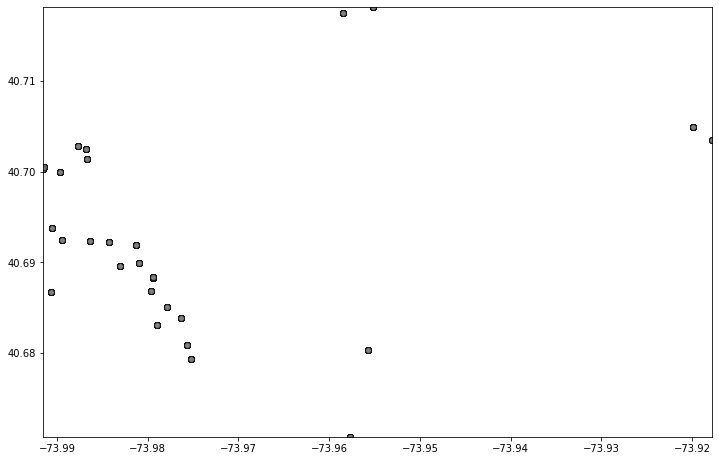

In [78]:
#y_lim = (2900000,3000000) # latitude
#x_lim = (200000, 400000) # longitude
#plot_map(sf, x_lim, y_lim)
#ax.set_xlim(minx, maxx)
#ax.set_ylim(miny, maxy)

fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_TOP10.total_bounds
y_lim = (miny,maxy)
x_lim = (minx,maxx)
plt.xlim(x_lim)
plt.ylim(y_lim)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5,edgecolor='black', color='grey',ax=ax);


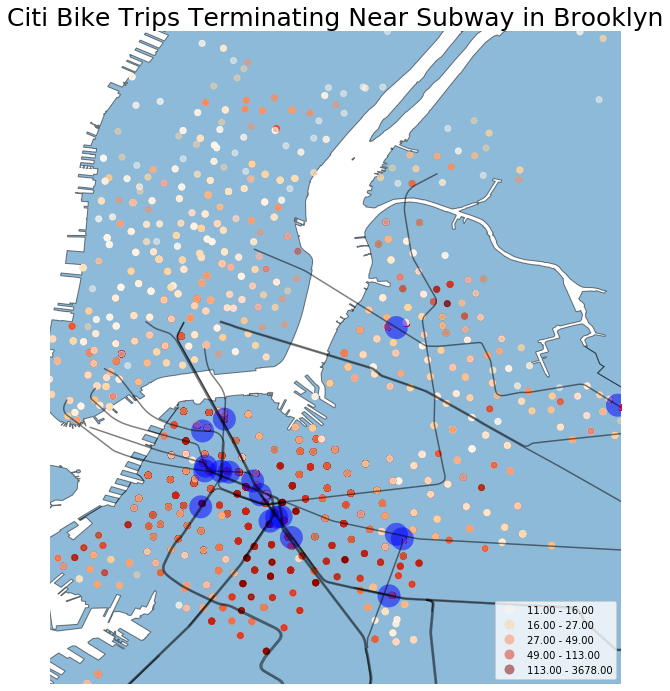

In [117]:
fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds
ylim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[1],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[3]])
xlim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[0],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[2]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
SCOPE.plot(alpha=.5,edgecolor='black',ax=ax)
ax.set_title("Citi Bike Trips Terminating Near Subway in Brooklyn", fontsize=25)
#BLYN_CITI_STATION_MERGED_START_TOP10_PATH.plot(alpha=.5,color='yellow',linewidth=.1, ax=ax)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_STATION_MERGED_START_TOP10.plot(alpha=.5, marker='o',cmap='OrRd', column='counts',
                                          scheme='quantiles',legend=True, 
                                          #legend_kwds={'label': "Number of Ride Orgins"},
                                          ax=ax)
#BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
PLOT_BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)


#plt.axis('equal')
ax.set_axis_off()


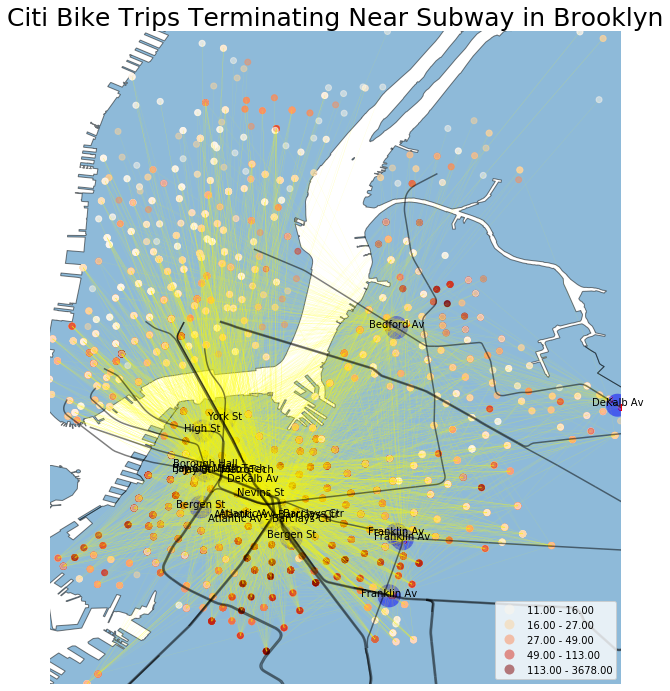

In [120]:
fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds
ylim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[1],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[3]])
xlim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[0],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[2]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
SCOPE.plot(alpha=.5,edgecolor='black',ax=ax)
ax.set_title("Citi Bike Trips Terminating Near Subway in Brooklyn", fontsize=25)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.plot(alpha=.5,color='yellow',linewidth=.1, ax=ax)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_STATION_MERGED_START_TOP10.plot(alpha=.5, marker='o',cmap='OrRd', column='counts',
                                          scheme='quantiles',legend=True, 
                                          #legend_kwds={'label': "Number of Ride Orgins"},
                                          ax=ax)
#BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
PLOT_BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)

PLOT_BLYN_STATION.apply(lambda x: ax.annotate(s=x['Stop Name'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


#plt.axis('equal')
ax.set_axis_off()


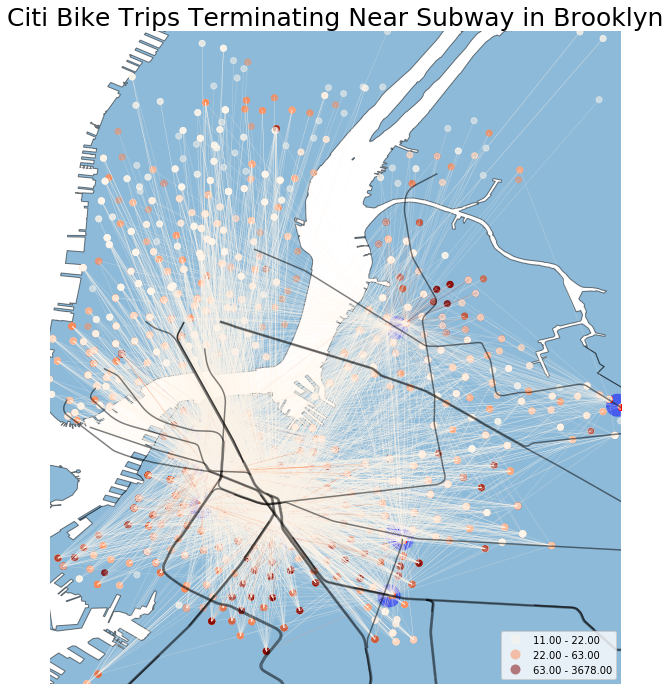

In [170]:
fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds
ylim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[1],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[3]])
xlim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[0],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[2]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
SCOPE.plot(alpha=.5,edgecolor='black',ax=ax)

ax.set_title("Citi Bike Trips Terminating Near Subway in Brooklyn", fontsize=25)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.plot(alpha=.5,cmap='OrRd', column='counts',
                                          scheme='fisher_jenks',
                                          k=3,
                                          linewidth=.3,
                                          #classification_kwds=dict(bins=[20,2000]),
                                          ax=ax)
PLOT_BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_STATION_MERGED_START_TOP10.plot(alpha=.5, marker='o',cmap='OrRd', column='counts',
                                          scheme='quantiles',legend=True, k=3,
                                          #legend_kwds={'label': "Number of Ride Orgins"},
                                          ax=ax)
#BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)

#PLOT_BLYN_STATION.apply(lambda x: ax.annotate(s=x['Stop Name'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


#plt.axis('equal')
ax.set_axis_off()


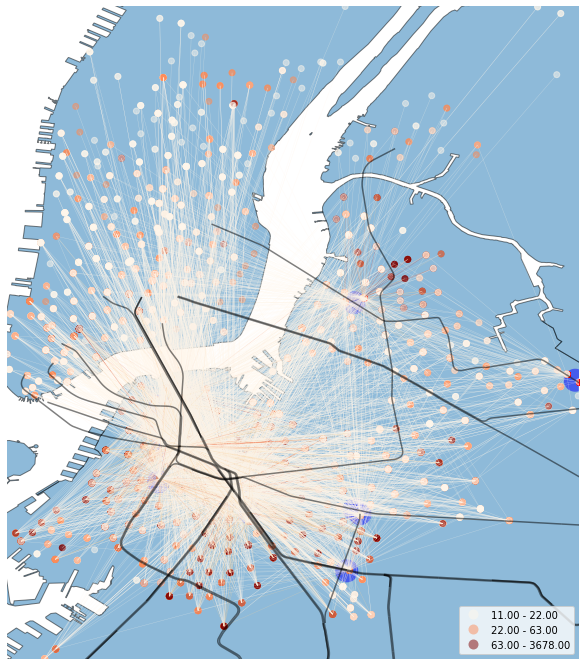

In [172]:
fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds
ylim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[1],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[3]])
xlim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[0],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[2]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
SCOPE.plot(alpha=.5,edgecolor='black',ax=ax)

#ax.set_title("Citi Bike Trips Terminating Near Brooklyn Subway", fontsize=25)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.plot(alpha=.5,cmap='OrRd', column='counts',
                                          scheme='fisher_jenks',
                                          #k=10,
                                          linewidth=.3,
                                          #markersize=BLYN_CITI_STATION_MERGED_START_TOP10_PATH['counts'],
                                          #classification_kwds=dict(bins=[20,2000]),
                                          ax=ax)
PLOT_BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_STATION_MERGED_START_TOP10.plot(alpha=.5, marker='o',cmap='OrRd', column='counts',
                                          scheme='quantiles',legend=True, k=3,
                                          #legend_kwds={'label': "Number of Ride Orgins"},
                                          ax=ax)
#BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)

#PLOT_BLYN_STATION.apply(lambda x: ax.annotate(s=x['Stop Name'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


#plt.axis('equal')
ax.set_axis_off()

fig.savefig('top10.jpeg')


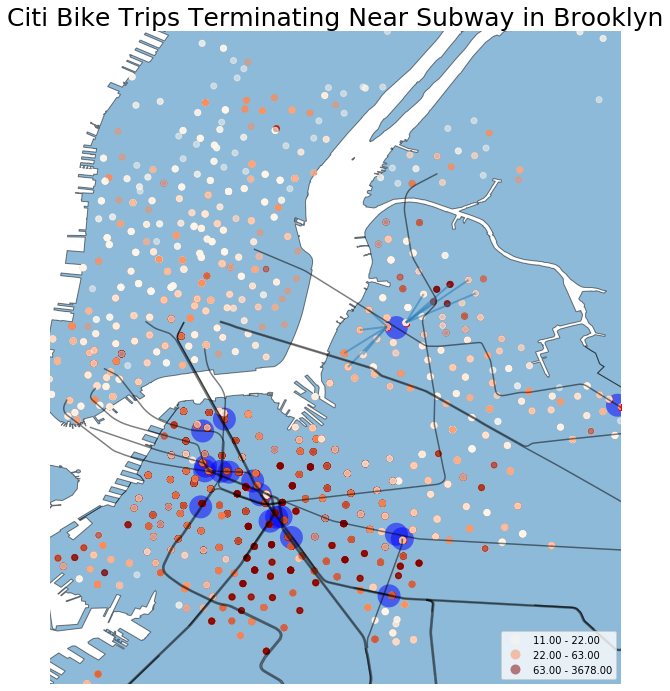

In [153]:
fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds
ylim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[1],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[3]])
xlim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[0],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[2]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
SCOPE.plot(alpha=.5,edgecolor='black',ax=ax)

ax.set_title("Citi Bike Trips Terminating Near Subway in Brooklyn", fontsize=25)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH.head(10).plot(alpha=.5,#cmap='OrRd', #column='counts',
                                          #scheme='fisher_jenks',
                                          #k=10,
                                          linewidth=2,
                                          #markersize=BLYN_CITI_STATION_MERGED_START_TOP10_PATH['counts'],
                                          #classification_kwds=dict(bins=[20,2000]),
                                          ax=ax)
PLOT_BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_STATION_MERGED_START_TOP10.plot(alpha=.5, marker='o',cmap='OrRd', column='counts',
                                          scheme='quantiles',
                                          legend=True, k=3,
                                          #legend_kwds={'label': "Number of Ride Orgins"},
                                          ax=ax)
#BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)

#PLOT_BLYN_STATION.apply(lambda x: ax.annotate(s=x['Stop Name'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


#plt.axis('equal')
ax.set_axis_off()


In [ ]:
# "clip" a points layer to the boundary of a polygon
#BLYN_CITI = CITI_DF[CITI_DF.geometry.intersects(BLYN.geometry.unary_union)]
#BLYN_CITI_END = CITI_DF_END[CITI_DF_END.geometry.intersects(BLYN.geometry.unary_union)]
#BLYN_CITI_END.to_file("BLYN_CITI_END.shp")

In [175]:
BLYN_CITI_STATION_MERGED_START_TOP10_PATH['Stop Name'].head(10);

BLYN_CITI_STATION_MERGED_START_TOP10

,Unnamed: 0,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,counts,...,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,count_x,count_y
0,115770,460.0,S 4 St & Wythe Ave,40.712859,-73.965903,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3678,...,Bedford Av,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283
1,127387,481.0,S 3 St & Bedford Ave,40.712605,-73.962644,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3448,...,Bedford Av,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283
2,160549,2002.0,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,3183,...,Bedford Av,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283
3,84114,389.0,Broadway & Berry St,40.710446,-73.965251,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,2117,...,Bedford Av,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283
4,190777,3100.0,Nassau Ave & Newell St,40.724813,-73.947526,3715.0,Driggs Ave & N 9 St,40.718170,-73.955201,2061,...,Bedford Av,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,1283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18426,64397,344.0,Monroe St & Bedford Ave,40.685144,-73.953809,3415.0,Prospect Pl & 6 Ave,40.679331,-73.975195,11,...,Bergen St,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507
18427,353288,3676.0,Van Brunt St & Van Dyke St,40.675833,-74.014726,3414.0,Bergen St & Flatbush Ave,40.680945,-73.975673,11,...,Bergen St,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507
18428,229485,3241.0,Monroe St & Tompkins Ave,40.686203,-73.944694,3415.0,Prospect Pl & 6 Ave,40.679331,-73.975195,11,...,Bergen St,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507
18429,103958,435.0,W 21 St & 6 Ave,40.741740,-73.994156,3415.0,Prospect Pl & 6 Ave,40.679331,-73.975195,11,...,Bergen St,Bk,2 3,Subway,40.680829,-73.975098,Manhattan,Flatbush - New Lots,1,1507


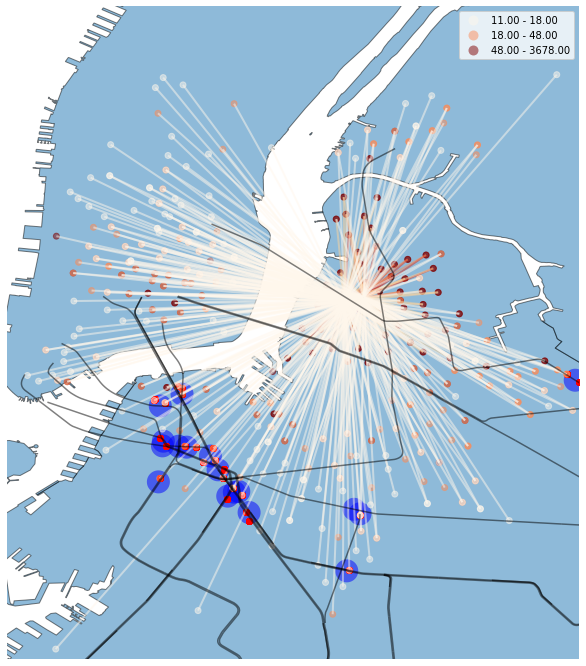

In [181]:
fig, ax = plt.subplots(figsize=(12, 12))
minx, miny, maxx, maxy = BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds
ylim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[1],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[3]])
xlim = ([BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[0],  BLYN_CITI_STATION_MERGED_START_TOP10.total_bounds[2]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
SCOPE.plot(alpha=.5,edgecolor='black',ax=ax)

#ax.set_title("Citi Bike Trips Terminating Near Bedford Subways", fontsize=25)
BLYN_CITI_STATION_MERGED_START_TOP10_PATH[BLYN_CITI_STATION_MERGED_START_TOP10_PATH['Stop Name']=='Bedford Av'].plot(alpha=.5,cmap='OrRd', column='counts',
                                          scheme='fisher_jenks',
                                          #k=10,
                                          linewidth=2,
                                          #markersize=BLYN_CITI_STATION_MERGED_START_TOP10_PATH['counts'],
                                          #classification_kwds=dict(bins=[20,2000]),
                                          ax=ax)
PLOT_BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_CITI_STATION_MERGED_TOP10.plot(alpha=.5, marker='o', color='red', ax=ax)
BLYN_CITI_STATION_MERGED_START_TOP10[BLYN_CITI_STATION_MERGED_START_TOP10['Stop Name']=='Bedford Av'].plot(alpha=.5, marker='o',cmap='OrRd', column='counts',
                                          scheme='quantiles',
                                          legend=True, k=3,
                                          #legend_kwds={'label': "Number of Ride Orgins"},
                                          ax=ax)
#BLYN_STATION.plot(alpha=.5, color='blue', ax=ax)
BLYN_LINES.plot(alpha=.5,color='black', ax=ax)

#PLOT_BLYN_STATION.apply(lambda x: ax.annotate(s=x['Stop Name'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


#plt.axis('equal')
ax.set_axis_off()
fig.savefig('bedford.jpeg')


In [174]:
BLYN_LINES.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,"LINESTRING (-73.99488 40.68020, -73.99427 40.6..."
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,"LINESTRING (-73.97958 40.65993, -73.97966 40.6..."
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,"LINESTRING (-73.97586 40.57597, -73.97654 40.5..."
6,2000239.0,G,759.0,G,2448.069200,http://web.mta.info/nyct/service/,"LINESTRING (-73.98510 40.68834, -73.98415 40.6..."
7,2000238.0,G,760.0,G,690.126468,http://web.mta.info/nyct/service/,"LINESTRING (-73.98510 40.68835, -73.98732 40.6..."
